In [67]:
import matplotlib.pyplot as plt
import numpy as np
import math
%matplotlib inline

In [68]:
def f(x):
    return x**2 + 5*x - 4

In [69]:
f(3.0)

20.0

In [70]:
x = np.arange(-5,5,0.25)
y = f(x)
y

array([ -4.    ,  -5.1875,  -6.25  ,  -7.1875,  -8.    ,  -8.6875,
        -9.25  ,  -9.6875, -10.    , -10.1875, -10.25  , -10.1875,
       -10.    ,  -9.6875,  -9.25  ,  -8.6875,  -8.    ,  -7.1875,
        -6.25  ,  -5.1875,  -4.    ,  -2.6875,  -1.25  ,   0.3125,
         2.    ,   3.8125,   5.75  ,   7.8125,  10.    ,  12.3125,
        14.75  ,  17.3125,  20.    ,  22.8125,  25.75  ,  28.8125,
        32.    ,  35.3125,  38.75  ,  42.3125])

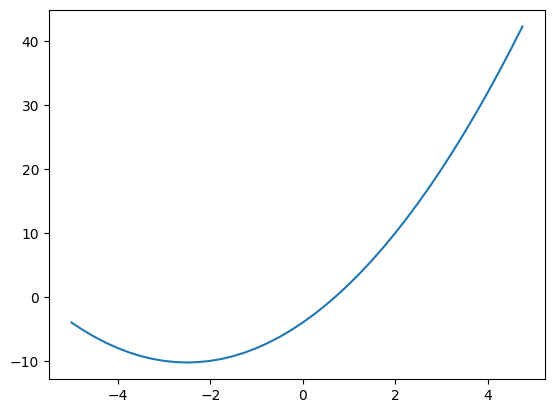

In [71]:
plt.plot(x,y)

In [72]:
h = 0.001

a = 2.0
b = -3.0
c = 10

d1 = a*b + c

# we pump (a)

da = (a+h)*b + c
db = a*(b+h) + c
dc = a*b + (c+h)

print("d",d1)
print("d as we pump a by h",da)
print("d as we pump b by h",db)
print("d as we pump c by h",dc)

# quiz calculate the slope of each one of them

d 4.0
d as we pump a by h 3.997
d as we pump b by h 4.002
d as we pump c by h 4.0009999999999994


In [216]:
class Value:
    def __init__(self, data,_children=(),_op='',label=''):
        # we put underscore, to mark variable for interanl class use.
        # TODO: make label daynamic and takes variable name as label
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self._backward = lambda : None
        self.label = label
        self.grad = 0.0 # the derivate of the node with resepct to the output value
    def __repr__(self):
        return f"Value(data={self.data})"
    def __add__(self,obj):
        obj = obj if isinstance(obj,Value) else Value(obj)
        out = Value(data = self.data + obj.data,_children=(self,obj),_op="+" )

        def _backward():
            self.grad += 1.0 * out.grad
            obj.grad += 1.0 * out.grad
        out._backward = _backward
        return out
              
    def __mul__(self,obj):
        obj = obj if isinstance(obj,Value) else Value(obj)
        out = Value(data=self.data * obj.data,_children=(self,obj),_op="*" )

        def _backward():
            self.grad += obj.data * out.grad
            obj.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __pow__(self,other):
        # make sure other, is a float or int 
        assert isinstance(other,(float,int)) , "supporting only float,int"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out
    def __rmul__(self,other): # other * self
        # here we will swap the order of operands
        return self * other
    def __radd__(self,other):
        return self + other
    def __truediv__(self,other):
        return self * other**-1
    def __rtruediv__(self,other):
        return other * self**1
    def __sub__(self,other):
        return self + (-other)
    def __rsub__(self,other):
        return other + (-self)
        
    def tanh(self):
        x = self.data
        n = (math.exp(2*x) - 1) / (math.exp(2*x) + 1 )
        out = Value(data = n,_children=(self,),_op='tanh')

        def _backward():
            self.grad += (1 - n**2) * out.grad
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x),(self,), 'exp') 

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    def backward(self):

        topo =[]
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        self.grad=1.0
        build_topo(self)
        
        for node in reversed(topo):
            node._backward()
                

In [217]:
a = Value(data=2.0,label='a')
b = Value(data=-3.0,label='b')
c = Value(data=10.0,label='c')
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(data=-2.0,label='f')
L = d * f; L.label = 'L'
d._prev
# a.__mul__(b).__add__(c)

{Value(data=-6.0), Value(data=10.0)}

now we can trackback the operation that made the variable, and the childeren that made up the value. ( that's kind of wrong, they must be called parents but whatever

In [218]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        # print(hasattr(n,'label'),n)
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f}" % (n.label,n.data,n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot


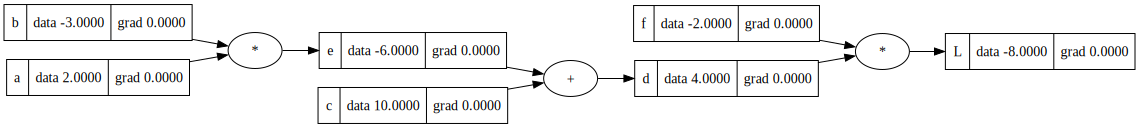

In [219]:
dot = draw_dot(L)
dot

In [220]:
L.grad = 1.0
d.grad = f.data
f.grad = d.data
c.grad = d.grad
e.grad = d.grad
a.grad = e.grad * b.data
b.grad = e.grad * a.data
# dL / da = dL / de * da / de
# backprobagation is a recusrive application of the chain rule 

In [221]:
# now we want to use gradiant value to nudge the output up. 
# this is the power of the gradiant information it gives us a guide into how to increase the output

a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad
# 0.01 is the step size
# we  do the forward pass again 


e = a * b
d = e + c
L = d * f

# we see L increase by how much
print(L.data)


-7.286496


In [222]:
# we want to examine gradiant for each node 
h = 0.001
def lol():
    a = Value(data=2.0,label='a')
    b = Value(data=-3.0,label='b')
    c = Value(data=10.0,label='c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
   
    f = Value(data=-2.0,label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(data=2.0,label='a')
    b = Value(data=-3.0,label='b')
    c = Value(data=10.0,label='c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd' ; d.data += h
    f = Value(data=-2.0,label='f')
    L = d * f; L.label = 'L'
    L2 = L.data 

    print( (L2-L1) / h)

lol()
    

-2.000000000000668


In [223]:
# we need two inputs x1,x2
# we need two weights w1,w2

x1 = Value(2.0,label='x1')
x2 = Value(0.0,label='x2')

w1= Value(-3.0,label='w1')
w2=Value(1.0,label='w2')

# bias 
b = Value(6.8813,label='b')

# multiply corespondents 
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2 ; x2w2.label = 'x2w2'
#add all
x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2.label = 'x1w1 + x2w2'
# add bias
n = x1w1x2w2 + b ; n.label = 'n'
o = n.tanh(); o.label ='o'

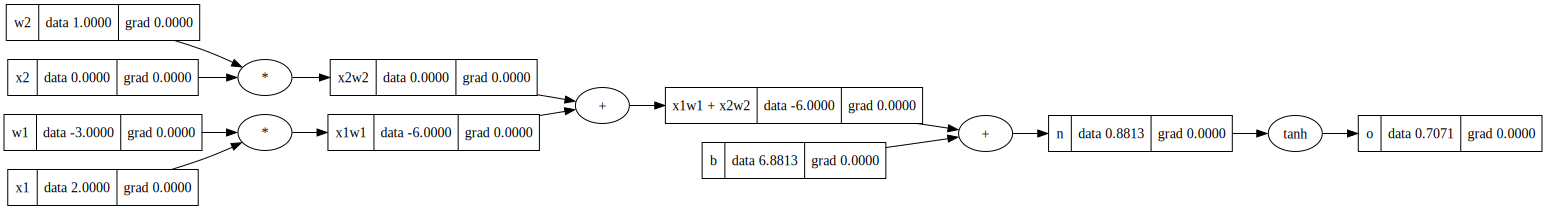

In [224]:
draw_dot(o)

In [225]:
o.backward()

In [226]:
o.grad = 1.0
'''
we want n.grad, 
do/dn and the operartion is tanh, what is the derivate of tanh ( 1- tanh**2)

gradiant tells us the influence of the node on the final output
'''
n.grad = 1 - o.data**2
b.grad = n.grad
x1w1x2w2.grad = n.grad
x1w1.grad = n.grad
x2w2.grad = n.grad

x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

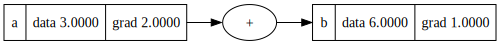

In [227]:
a = Value(3.0,label='a')
b = a + a ;b.label='b'
b.backward()
draw_dot(b)

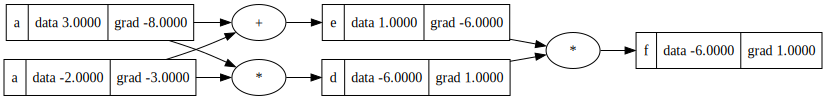

In [228]:
a = Value(-2.0,label='a')
b = Value(3.0,label='a')
d = a * b ;d.label='d'
e = a + b ;e.label='e'
f = d * e ;f.label='f'
f.backward()
draw_dot(f)


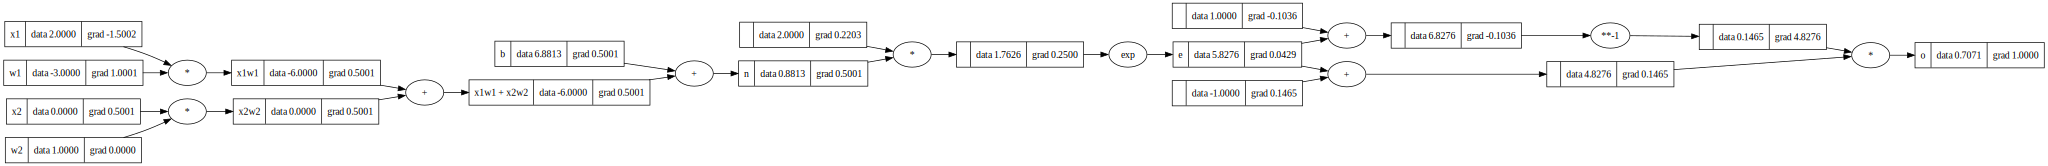

In [229]:
# we need two inputs x1,x2
# we need two weights w1,w2

x1 = Value(2.0,label='x1')
x2 = Value(0.0,label='x2')

w1= Value(-3.0,label='w1')
w2=Value(1.0,label='w2')

# bias 
b = Value(6.8813,label='b')

# multiply corespondents 
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2 ; x2w2.label = 'x2w2'
#add all
x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2.label = 'x1w1 + x2w2'
# add bias
n = x1w1x2w2 + b ; n.label = 'n'
# tanh-----------------
e = (2*n).exp() ;e.label = 'e'
o = (e - 1 ) / (e + 1) ; o.label = 'o'

o.backward()
draw_dot(o)

In [230]:
import torch
import numpy as np
import random

In [231]:
x1 = torch.tensor([2.0]).double() ;x1.requires_grad = True
x2 = torch.tensor([0.0]).double() ;x2.requires_grad = True
w1 = torch.tensor([-3.0]).double() ;w1.requires_grad = True
w2 = torch.tensor([1.0]).double() ;w2.requires_grad = True
#define bias
b = torch.tensor([6.8813]).double() ;b.requires_grad = True
n = x1*w1 + x2*w2 + b
# activation function ( tanh)
o = torch.tanh(n)
print(o)
o.backward()
# print all grads after backward pass
print(x1.grad.item(),x2.grad.item(),w1.grad.item(),w2.grad.item())

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)
-1.5001561639694192 0.5000520546564731 1.0001041093129461 0.0


the way a neural network works is a follows
1- nn -> * layers -> * neurons
for each neuron -> * Xs (data), Ws (weights), B which is the bias this neuron produces a number
that is then passed to an activation function

In [791]:
class Neuron:
    def __init__(self,num_ws):
        # dimensoin of the nueron
        self.ws = [ Value(random.uniform(-1,1)) for _ in range(num_ws) ]
        self.b  =  Value(random.uniform(-1,1))
    def __call__(self,xs):
        assert len(xs) == len(self.ws),"number of wights does not match number of data"
        act = sum(([x*w for x,w in zip(xs,self.ws)]),self.b) 
        o = act.tanh()
        return o
    def parameters(self):
        return self.ws + [self.b] 
        
        

class Layer:
    def __init__(self,n_dim,n_out):
        self.neurons = [Neuron(n_dim) for _ in range(n_out)]
    def __call__(self,x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()] 
class MLP:
    def __init__(self,num_xs,num_neu):
        # we want to take two consctuve pair in this list     
        specs = [num_xs] + num_neu 
        self.layers = [Layer(specs[i],specs[i+1]) for i in range(len(num_neu))]

    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [l for layer in self.layers for l in layer.parameters()] 
# ideal API
xs = [
    [2.0,3.0,-1.0],
     [3.5,-1.0,0.5],
     [2.5,1.0,1.5],
      [2.0,-3.0,-1.0]
    ]
ys = [1.0,-1.0,-1.0,1.0]

n = MLP(3,[4,4,1])
len(n.parameters())

41

In [792]:
# data to train on and desired output for that data
# if we pass [2,3,1] we would like to have 1 as an output
# here we kinda merge 4 MLPs into one NN the we combine them by having one loss function
# and backward towards that, and that is going to call each MLP alone and do their stuff

In [802]:
for step in range(20):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((p - y)**2 for y,p in zip(ys,ypred))
    
    #backward pass
    loss.backward()

    # optimization
    for p in n.parameters():
        p.data += -0.01 * p.grad

    #zero all grads
    for p in n.parameters():
        p.grad= 0.0
    print(f"step :{step+1}, loss: {loss.data}")


step :1, loss: 0.05970644434051804
step :2, loss: 0.05899163162745602
step :3, loss: 0.058292070796421624
step :4, loss: 0.05760730925102118
step :5, loss: 0.05693691118701352
step :6, loss: 0.05628045685984043
step :7, loss: 0.055637541888160266
step :8, loss: 0.05500777659145824
step :9, loss: 0.054390785359912916
step :10, loss: 0.053786206054804636
step :11, loss: 0.053193689437846026
step :12, loss: 0.05261289862790605
step :13, loss: 0.05204350858368522
step :14, loss: 0.05148520561098088
step :15, loss: 0.05093768689325676
step :16, loss: 0.05040066004430334
step :17, loss: 0.04987384268184302
step :18, loss: 0.04935696202099829
step :19, loss: 0.048849754486600366
step :20, loss: 0.04835196534337306


In [804]:
ypred = [n(x) for x in xs]
ypred

[Value(data=0.886792477983871),
 Value(data=-0.8850273280020962),
 Value(data=-0.912994512500527),
 Value(data=0.8805900542639421)]